# Introduction
On this project we are going to analyze New York's published [student SAT schools](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4), along with some other demographic data sets.
The purpose of this project is whether the SAT is a fare test or not because New York city is diverse and has a lot of immigrants, different incomes, races and a lot of demographic factors, so we can say that the question we hope to answer with this project is the SAT exam biased to some demographic factors and what are they? 
## A view over datasets

   - [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
   - [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
   - [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
   - [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
   - [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
   - [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
   - [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school


# Read in the data

In [25]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [26]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\Abd-Elrahman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


# Add DBN columns

In [27]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [28]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [29]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [30]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [31]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [32]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [33]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [34]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

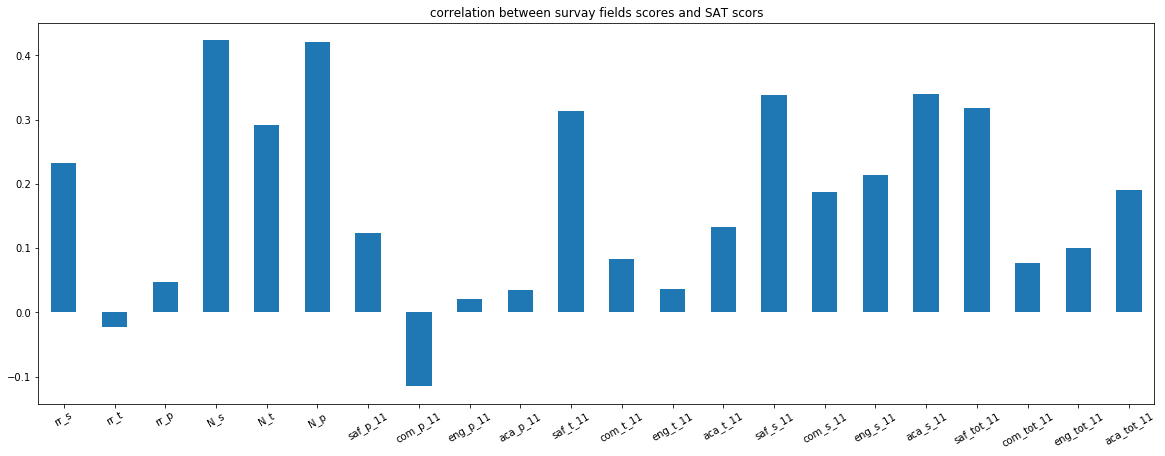

In [35]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar(figsize=(20,7),rot=30, title='correlation between survay fields scores and SAT scors')

The meaning of the survey fields can be found [here](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8).<br>
    ``N_s`` and ``N_t`` have the highest correlation with SAT score and that makes sense since they are related to the total enrollment number of students. we can see that the fields corresponding to safety,``saf_t_11``,``saf_s_11``,and ``saf_tot_11``, has high correlation to SAT score.<br>
 what's surprising is that the response rate to the survey(``rr_s``) has high correlation with the SAT scores, which may indicate that the students with higher engagement are more likely to do better on their SAT test.
The most interesting thing in what we have seen is the high correlation between safety and the SAT score so next we are going to take a closer look to see how safety affect students, which areas are dangerous?
# Closer look over safety
``saf_s_11`` represents the safety score corresponding to the students response. So we are going to look how does students do on their SAT when they are feeling not safe.

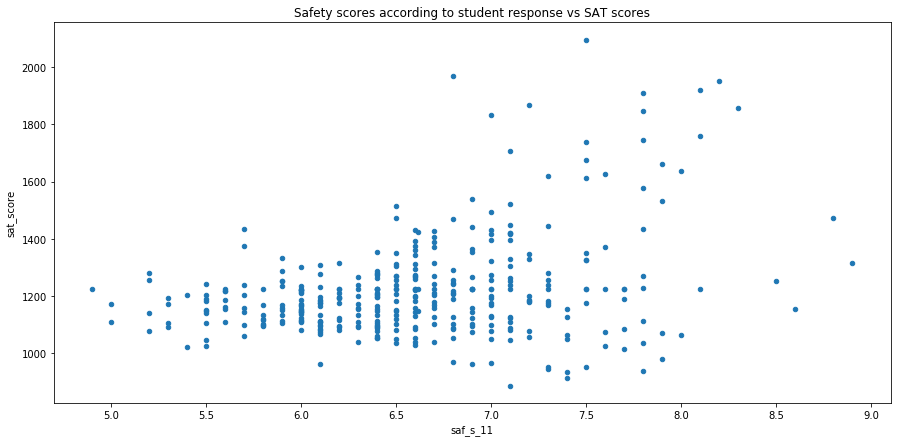

In [36]:
combined.plot.scatter('saf_s_11','sat_score', title='Safety scores according to student response vs SAT scores'
                      ,figsize = (15,7))

We can see that the average SAT scores at schools with safety score less that 7 are barely reaching 1500, and with safety hight than 7 we can see the scores getting higher.<br>
Now lets view the safety scores over New York map to see if we can find any relations. 

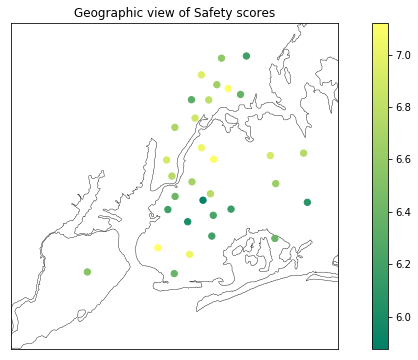

In [37]:
import matplotlib.pyplot as plt
import os
os.environ['PROJ_LIB'] = r'C:\Users\Abd-Elrahman\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

plt.figure(figsize=(12,6))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution = 'f'
)

#m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='black', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)


longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
g=m.scatter(longitudes, latitudes, s=40, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.colorbar(g)
plt.title('Geographic view of Safety scores')
plt.show()

It looks like Brooklyn is least safe area in New York.

# How race effect the SAT scores?

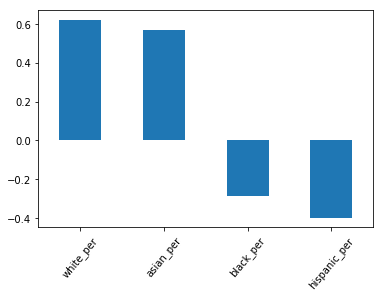

In [38]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar(rot=50)

As we can see the percentage of white and Asians are positively correlated with the SAT scores unlike the black and Hispanic percentage. But does that means that the scores are biased or there is another reason? let's take a look at schools with high percentage of Hispanic and black people and see what we can find.

In [39]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [40]:
print(combined[combined["black_per"] > 95]["SCHOOL NAME"])

235    MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
Name: SCHOOL NAME, dtype: object


With a simple Google search we can find that these schools either host immigrant and as they are not native speakers it is expected that they will have average score less than other schools.
# How Gender effect the SAT scores?

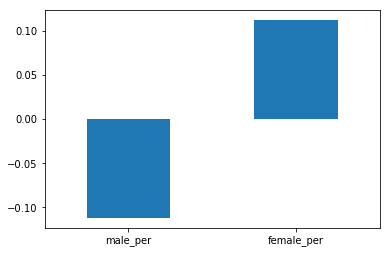

In [41]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar(rot=0)

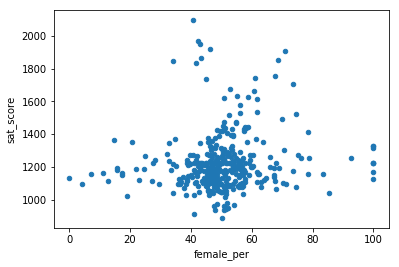

In [42]:
combined.plot.scatter("female_per",'sat_score')

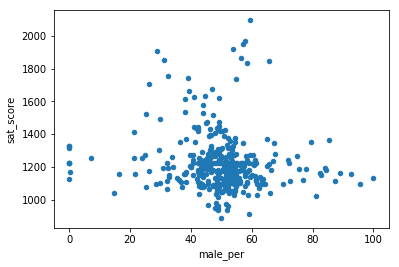

In [43]:
combined.plot.scatter("male_per",'sat_score')

Even though we can see that the male percentage is negatively correlated and the female percentage is positively correlated with the SAT Score, we can't state that there is a role that gender plays in the SAT exam because the correlation is so weak, and it does not appear to be any relationship in the scatter plot.
# AP test vs SAT test

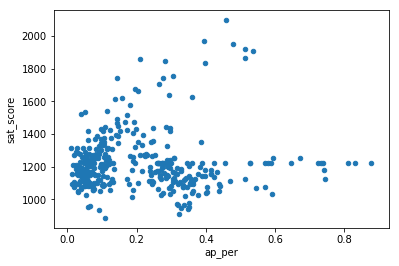

In [44]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter('ap_per', 'sat_score')

It does not seem to be any relationship between the AP test takers and the SAT average scores.
# Class size effect over the SAT test

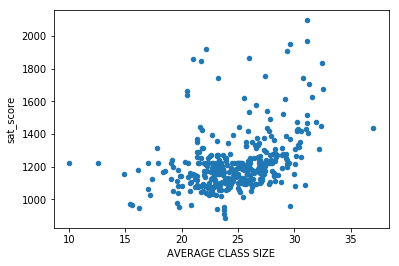

In [45]:
combined.plot.scatter('AVERAGE CLASS SIZE','sat_score')

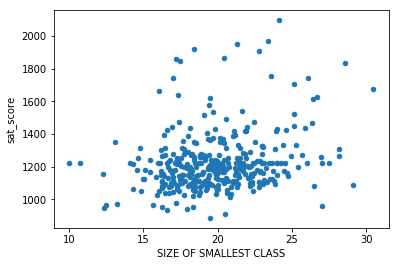

In [46]:
combined.plot.scatter('SIZE OF SMALLEST CLASS','sat_score')

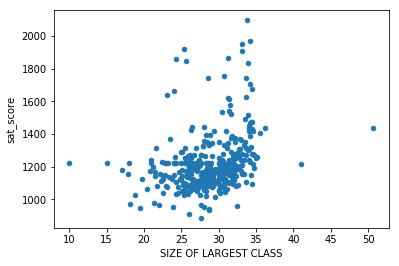

In [47]:
combined.plot.scatter('SIZE OF LARGEST CLASS','sat_score')

It does not seems to be a strong correlation but we can see that when the average class size is 20 or less the scores does not reach 1400.<br>
Now lets look at the sat Scores over districts to see which district has better schools

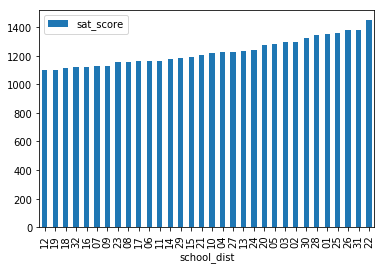

In [48]:
dist_sat = combined[['school_dist', 'sat_score']]
dist_sat.groupby('school_dist').agg('mean').sort_values('sat_score').plot.bar()

<b>Next we are going to assign scores to schools based on their attributes and answer the following question:<br> what is the best affordable schools in NYC?<b>